In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using FITSIO
using LinearAlgebra
using PythonCall
using ForwardDiff
np = pyimport("numpy")

Python module: <module 'numpy' from '/home/jaime/.julia/environments/v1.7/.CondaPkg/env/lib/python3.11/site-packages/numpy/__init__.py'>

In [2]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "LSST"
data_set = "wlwl_Nzs40"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [171]:
isposdef(cov_k0)

true

## T-Matrices

In [3]:
function model_cov0(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => x,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => x,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => x,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => x,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [38]:
d = 0.005
n_cls = 240
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
end

40


In [39]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [40]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3';

In [41]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  7.75874e19  -5.92402e18  -6.08311e18  …   8.70209e17   1.06591e18
 -5.92402e18   1.55592e20  -7.44602e18      5.34593e17   7.17932e17
 -6.08311e18  -7.44602e18   2.42528e20      4.66063e17   5.9713e17
 -6.07044e18  -7.44893e18  -7.86147e18      5.42869e17   6.8342e17
 -6.04641e18  -7.41234e18  -7.84896e18      7.35288e17   9.09825e17
 -5.99192e18  -7.32726e18  -7.77351e18  …   9.66828e17   1.17028e18
 -5.95645e18  -7.26202e18  -7.70935e18      1.18117e18   1.40855e18
 -6.32542e18  -7.68861e18  -8.16333e18      1.46733e18   1.73003e18
 -7.28416e18  -8.82745e18  -9.37046e18      1.91949e18   2.23865e18
 -8.23545e18  -9.95201e18  -1.05594e19      2.38519e18   2.74651e18
 -9.17038e18  -1.10543e19  -1.17224e19  …   2.80337e18   3.17571e18
 -1.04594e19  -1.25828e19  -1.33357e19      3.24768e18   3.59767e18
 -1.16849e19  -1.40366e19  -1.487e19        3.52753e18   3.77976e18
  ⋮                                     ⋱               
  7.01348e16  -1

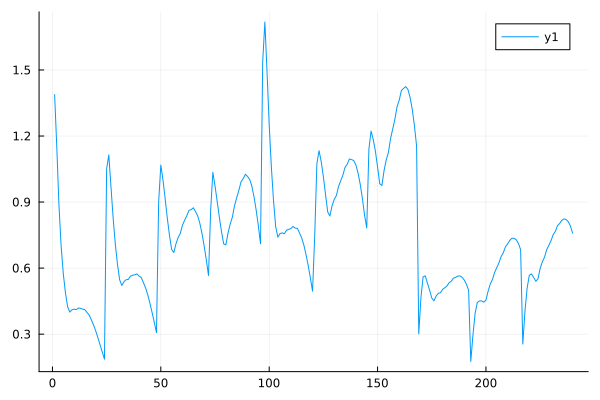

In [42]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [44]:
npzwrite("../data/DESY1/binned_40_nzs/cov_marg_lsst.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## Likelihood

In [45]:
pars = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
         1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
        -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
         2.389208e-01,   -6.435288e-01, 
         1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
        -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
         8.536883e-01,    2.535825e-01];

In [46]:
function get_cls(Ωm, s8;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;


In [55]:
function get_Xi2(Ωm, s8;
                 tk_mode="EisHu",
                 data_vector=data_vector,
                 inv_cov=inv_cov_tot)

        nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [65]:
Ωms = LinRange(0.2, 0.6, 20)
s8s = LinRange(0.6, 0.9, 20)

20-element LinRange{Float64, Int64}:
 0.6,0.615789,0.631579,0.647368,0.663158,…,0.852632,0.868421,0.884211,0.9

In [66]:
get_Xi2(pars[26], pars[25])

1122.5443008851946

In [67]:
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

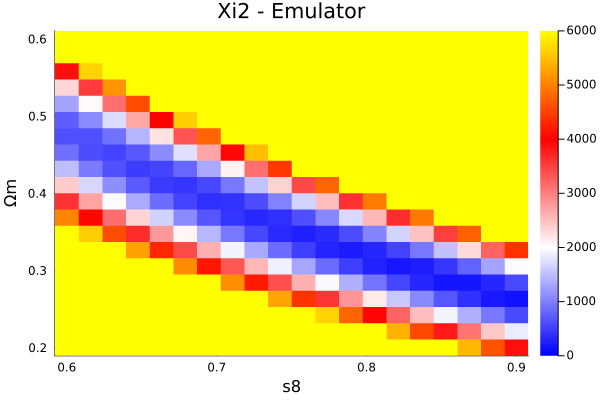

In [73]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_EisHu,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clim=(0, 6000),
    title="Xi2 - Emulator")

In [69]:
n_samples = 100
cls = zeros(240, n_samples)
for i in 1:n_samples
    Ωm = rand(Uniform(0.2, 0.6))
    s8 = rand(Uniform(0.6, 0.9))
    cls[:, i] = get_cls(Ωm, s8)
end

In [70]:
npzwrite("Nz_cls_lsst.npz", Dict("cls" => cls))

## Turing

In [46]:
chain = sample(model(fake_data), NUTS(adaptation, TAP, ),
               MCMCDistributed(), iterations, nchains, progress=true; save_state=true)

LoadError: UndefVarError: fake_data not defined